In [27]:
from ultralytics import YOLO
import ultralytics
from pathlib import Path
from IPython.display import Image, display
from pathlib import Path
import os
import pandas as pd
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

# Disable MLflow callback to prevent tracking errors
ultralytics.settings.update({'mlflow': False})

# Path to the dataset YAML file from Notebook 02
DATA_CONFIG = Path("Weed-crop RGB dataset/Corn_augmented/corn_original.yaml")
MODEL_NAME = "yolo11n.pt"
OUTPUT_DIR = Path("runs/corn_original_dataset_yolov11n")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#Baseline model path 
BASELINE_MODEL_PATH = Path("runs/corn_baseline_yolov11n/training_results/weights/best.pt")


# Ablation study - what do we expect to happen?

The core challenge in applying object detection to this agricultural dataset is the severe class imbalance between the majority crop ('Corn') and the minority weed classes. To address this, we implemented a context-aware undersampling strategy focused on mitigating noise caused by low-context 'Corn' instances at image borders. This targeted preprocessing successfully reduced the majority class instance count by 40.0%. We expect model to achieve better 

In [6]:
JSON_FILE_PATH = 'Weed-crop RGB dataset/Corn_augmented/corn_augmented_stats.json'
CORN_CLASSES_FILE = Path("Weed-crop RGB dataset/Corn_augmented/classes.txt")

def load_class_names_from_file(file_path):
    with open(file_path, 'r') as f:
        class_names = {str(i): line.strip() for i, line in enumerate(f)}
    return class_names

CLASS_NAMES = load_class_names_from_file(CORN_CLASSES_FILE)
with open(JSON_FILE_PATH, 'r') as f:
    stats_data = json.load(f)

df_stats = pd.DataFrame.from_dict(stats_data, orient='index').T
df_stats = df_stats.fillna(0).astype(int) 
df_stats['deleted instances'] = df_stats['train'] - df_stats['train_augmented']
new_index_names = [CLASS_NAMES.get(idx, idx) for idx in df_stats.index.astype(str)]
df_stats.index = new_index_names
columns_to_display = ['train', 'train_augmented', 'deleted instances']
print("--- Detailed Class Distribution and Augmentation Impact ---")
display(df_stats[columns_to_display])

--- Detailed Class Distribution and Augmentation Impact ---


,train,train_augmented,deleted instances
Corn,1358,815,543
Redroot Pigweed,99,99,0
Waterhemp,88,88,0
Horseweed,46,46,0
Ragweed,102,102,0
Kochia,76,76,0
Field Pea,7,5,2


### Load Model and Train

In [ ]:
# Load model and start training
model = YOLO(MODEL_NAME)
train_results = model.train(
    data=str(DATA_CONFIG),
    epochs=100,
    imgsz=640,
    batch=4,
    name="training_results",
    project=OUTPUT_DIR,
    device=0,  
    patience=20 # early stopping
)

Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Weed-crop RGB dataset/Corn_augmented/corn_original.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training_results, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

### Evaluate Best Model (defined on val dataset) on Test Dataset

In [19]:
BEST_MODEL_PATH = Path(OUTPUT_DIR) / 'training_results' / 'weights' / 'best.pt'

print(f"Loading best model from: {BEST_MODEL_PATH}")

#eval model that reached best results on val dataste
final_model = YOLO(BEST_MODEL_PATH)

print("\n--- Final Evaluation on TEST Dataset ---")

metrics = final_model.val(
    data=DATA_CONFIG, 
    split='test',      
    imgsz=640
)

print(metrics)
print("\n--- Results on Test Set ---")
print(f"Mean Average Precision (mAP50-95): {metrics.box.map:.4f}")
print(f"mAP50 (Test): {metrics.box.map50:.4f}")
print(f"Recall (Test): {metrics.box.mr.mean():.4f}")

Loading best model from: runs/corn_original_dataset_yolov11n/training_results/weights/best.pt

--- Final Evaluation on TEST Dataset ---
Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4229.6±604.7 MB/s, size: 8120.6 KB)
val: Scanning /home/jula/Repositories/CV/project/Crop-weed-detection/Weed-crop RGB dataset/Corn_augmented/test.cache... 14 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14/14 43.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.3it/s 3.6s
                   all         14        192      0.771      0.838      0.902      0.513
                  Corn         14        153      0.892       0.98      0.986      0.656
             Horseweed          4          6      0.641          1      0.972       0.48


### Visualize Training and Validation Curves

Found training curve plot:


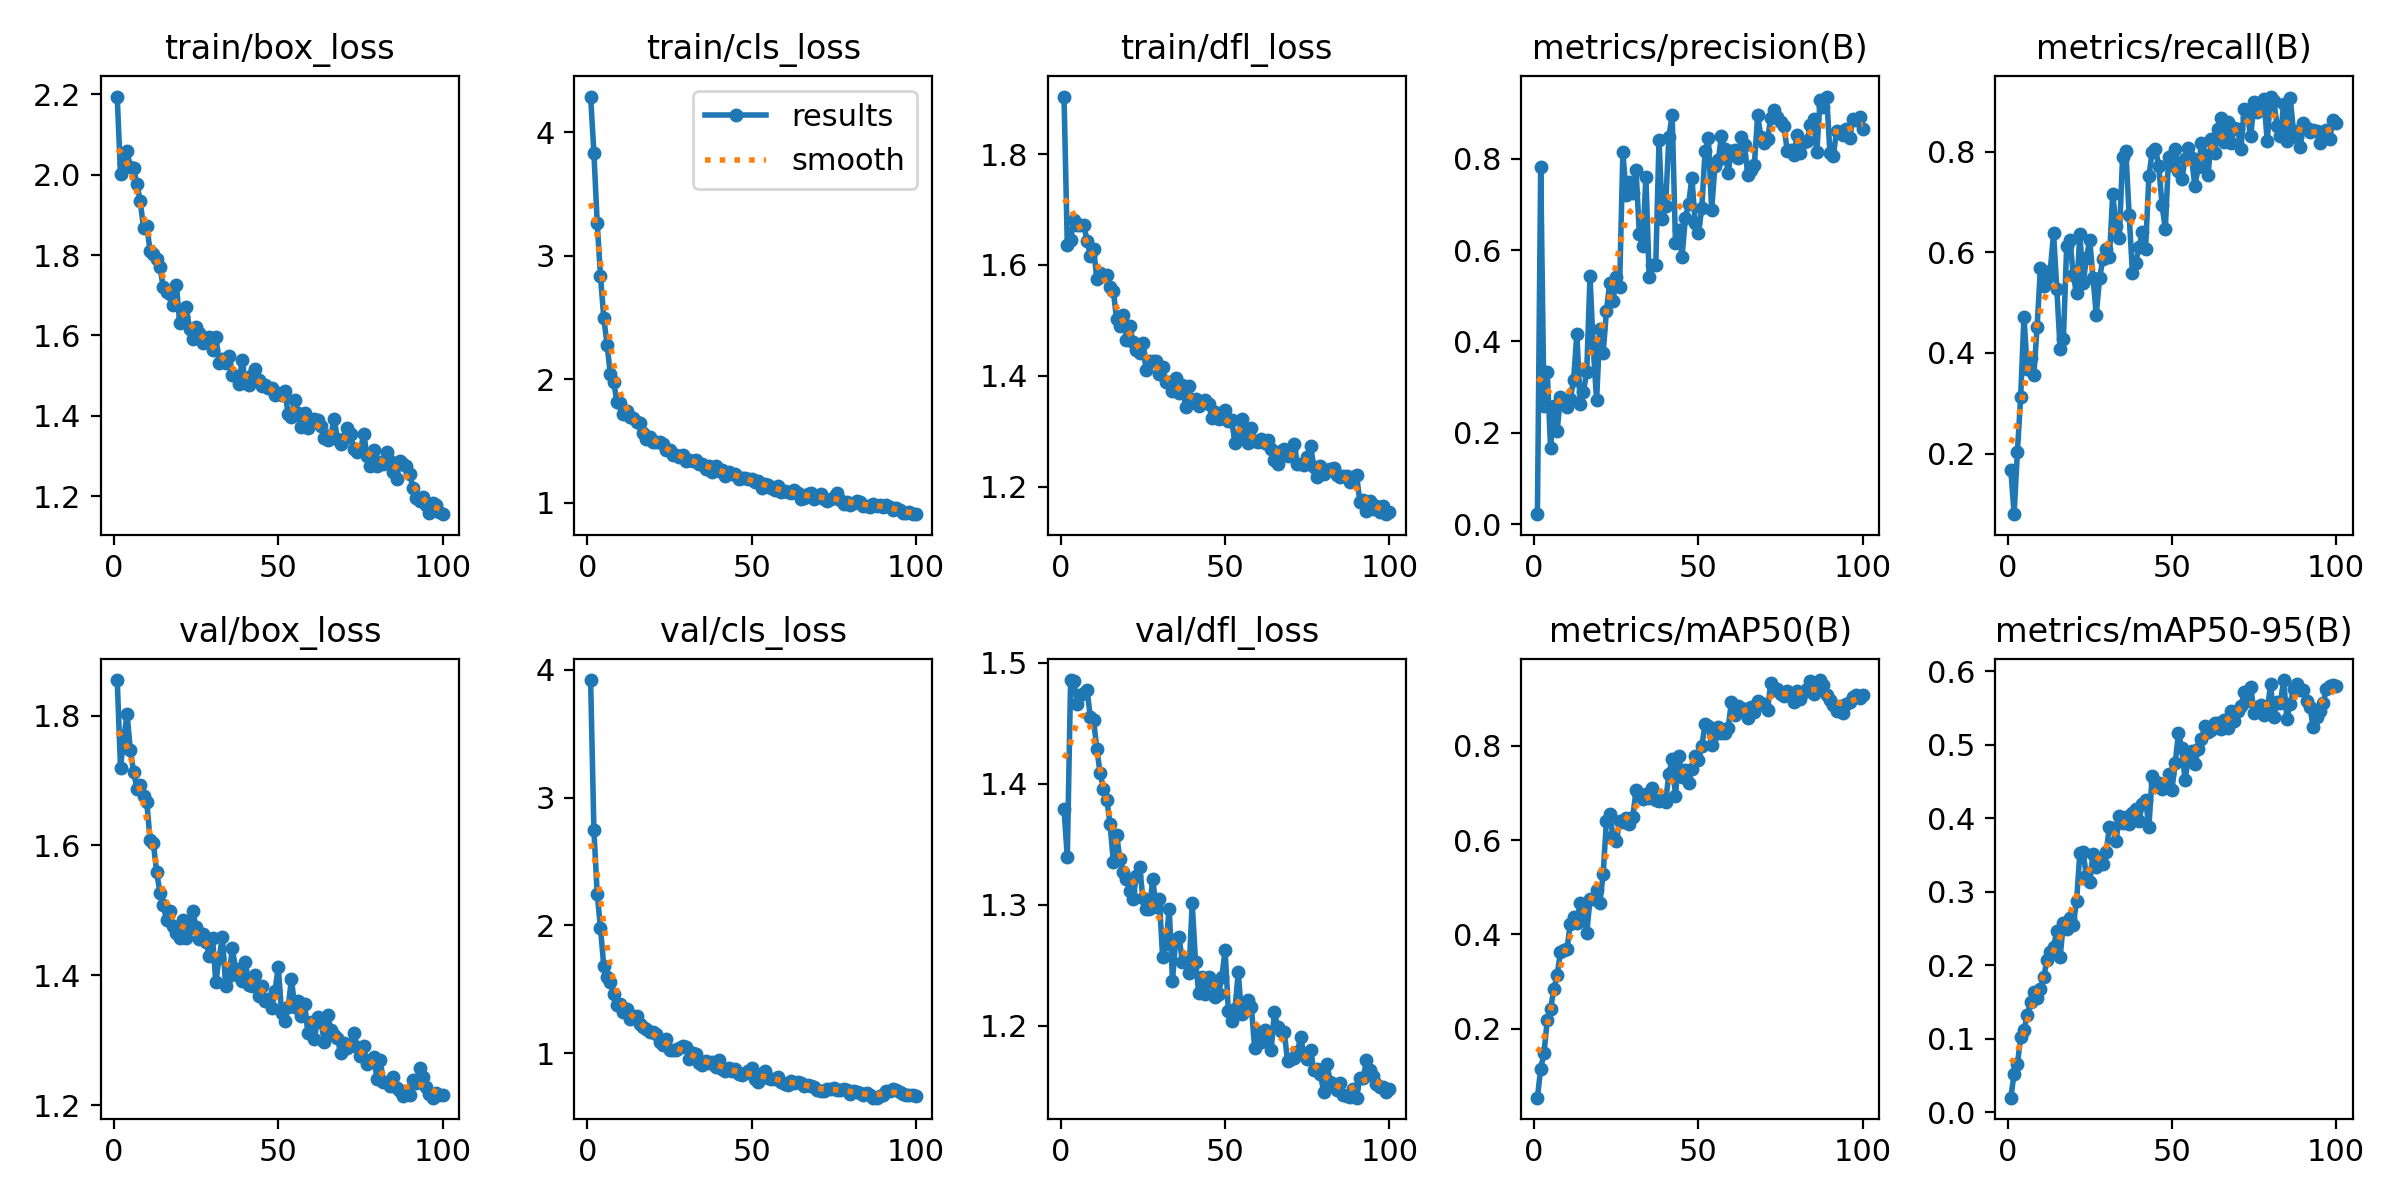

In [10]:
RUNS_BASE_DIR = Path(OUTPUT_DIR) / 'training_results'

results_plot = RUNS_BASE_DIR/'results.png'

if results_plot.exists():
    print("Found training curve plot:")
    display(Image(filename=str(results_plot))) 
else:
    print("'results.png' not found. Check if training ran successfully.")



### Save Model Export

In [11]:
# Export trained model weights for future notebooks
export_path = OUTPUT_DIR / "corn_yolo11n_baseline.pt"
model.save(export_path)
print(f"Model saved to: {export_path}")

Model saved to: runs/corn_original_dataset_yolov11n/corn_yolo11n_baseline.pt


### Baseline model evaluation - YOLOv11 on preprocessed dataset

In [14]:
baseline_model = YOLO(BASELINE_MODEL_PATH)

baseline_metrics = baseline_model.val(
    data=DATA_CONFIG, 
    split='test',      
    imgsz=640
)
print("Baseline metrics calculated.")

base_metrics = baseline_metrics

Ultralytics 8.3.226 🚀 Python-3.12.3 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7817MiB)
YOLO11n summary (fused): 100 layers, 2,584,687 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 924.0±66.2 MB/s, size: 8825.8 KB)
val: Scanning /home/jula/Repositories/CV/project/Crop-weed-detection/Weed-crop RGB dataset/Corn_augmented/test.cache... 14 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 14/14 41.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 0.4it/s 2.7s
                   all         14        192      0.711      0.731      0.779      0.452
                  Corn         14        153      0.862      0.967      0.966      0.626
             Horseweed          4          6      0.667      0.667      0.762      0.402
                Kochia          3          4      0.725       0.75      0.822      0.404
               Ragweed          7         11     

### Report

In [15]:
def extract_class_metrics(metrics_obj, label):
    ap50_arr = metrics_obj.box.ap50.flatten()
    ap_arr = metrics_obj.box.ap.flatten()
    class_names_list = metrics_obj.names
    nc_evaluated = len(ap50_arr) 

    data_list = []
    for i in range(nc_evaluated): 
        data_list.append({
            'Class': class_names_list[i], 
            f'mAP@0.5 ({label})': ap50_arr[i],
            f'mAP@0.5:0.95 ({label})': ap_arr[i]
        })

    df = pd.DataFrame(data_list)
    df = df[(df[f'mAP@0.5 ({label})'] > 0) | (df[f'mAP@0.5:0.95 ({label})'] > 0)]
    df.set_index('Class', inplace=True)
    return df

def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr
    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)'],
        label: [metrics_obj.box.map50, metrics_obj.box.map, precision, recall]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [23]:
def extract_general_metrics(metrics_obj, label):
    
    mp = metrics_obj.box.mp
    mr = metrics_obj.box.mr
    
    total_time_ms = metrics_obj.speed['preprocess'] + metrics_obj.speed['inference'] + metrics_obj.speed['postprocess']
    fps = 1000 / total_time_ms 
    
    precision = mp.mean() if hasattr(mp, 'mean') else mp
    recall = mr.mean() if hasattr(mr, 'mean') else mr

    #ap_small = metrics_obj.box.ap[7] if len(metrics_obj.box.ap) > 7 else 0 

    
    data = {
        'Metric': ['mAP@0.5', 'mAP@0.5:0.95', 'Precision (P)', 'Recall (R)', 
                   #'AP_Small (APs)', 
                   'Inference FPS'],
        label: [
            metrics_obj.box.map50, 
            metrics_obj.box.map, 
            precision, 
            recall,
            #ap_small, 
            fps # Dodano FPS
        ]
    }
    df = pd.DataFrame(data).set_index('Metric')
    return df

In [26]:

df_augmented_general = extract_general_metrics(base_metrics, 'Augmented')
df_original_general = extract_general_metrics(metrics, 'Original')

df_general_comparison = df_augmented_general.join(df_original_general, how='outer')
df_general_comparison['Difference'] = df_general_comparison['Original'] - df_general_comparison['Augmented']

print("\n--- Model Comparison: Overall Metrics  ---")
display(df_general_comparison.round(4))

df_augmented_class = extract_class_metrics(base_metrics, 'Augmented')
df_original_class = extract_class_metrics(metrics, 'Original')

df_class_comparison = df_augmented_class.join(df_original_class, how='outer').fillna(0)
df_class_comparison['Diff mAP@0.5'] = df_class_comparison['mAP@0.5 (Original)'] - df_class_comparison['mAP@0.5 (Augmented)']
df_class_comparison['Diff mAP@0.5:0.95'] = df_class_comparison['mAP@0.5:0.95 (Original)'] - df_class_comparison['mAP@0.5:0.95 (Augmented)']

print("\n--- Model Comparison: Class-Wise Details ---")
display(df_class_comparison.round(4))


--- Model Comparison: Overall Metrics  ---


,Augmented,Original,Difference
Metric,,,
Inference FPS,64.1286,192.8414,128.7127
Precision (P),0.7109,0.7712,0.0602
Recall (R),0.7306,0.8384,0.1079
mAP@0.5,0.7787,0.9021,0.1234
mAP@0.5:0.95,0.4525,0.5126,0.0602



--- Model Comparison: Class-Wise Details ---


,mAP@0.5 (Augmented),mAP@0.5:0.95 (Augmented),mAP@0.5 (Original),mAP@0.5:0.95 (Original),Diff mAP@0.5,Diff mAP@0.5:0.95
Class,,,,,,
Blackbean,0.9656,0.6256,0.9856,0.6560,0.0200,0.0304
Canola,0.7618,0.4021,0.9721,0.4799,0.2103,0.0778
Corn,0.8219,0.4042,0.8492,0.3623,0.0272,-0.0420
Field Pea,0.7652,0.5006,0.8728,0.5357,0.1076,0.0351
Flax,0.6368,0.3196,0.8425,0.4507,0.2057,0.1311
Horseweed,0.7207,0.4626,0.8904,0.5912,0.1697,0.1286


**mAP@0.5** - Mean Average Precision at IoU ≥50%. Measures if the model successfully identifies the object with reasonable overlap.

**mAP@0.5:0.95** - Mean of Average Precisions across IoU thresholds from 50% to 95%. It's a highly sensitive metric that measures how precisely the model predicts the exact location and shape of the bounding box.

A high mAP@0.5 but low mAP@0.5:0.95 means the model detects objects well but struggles with precise localization (it can't pinpoint the exact borders of the weed).

**Metric interpretation:**
* Weeds (Horseweed): Decreased by 12.86% (−0.1286). The intended targets (minority classes) were negatively affected by the augmentation.
* Crops (Blackbean, Canola, Flax): Decreased significantly (up to −0.1311 for Flax). The aggressive cutting removed valuable contextual information needed to distinguish healthy crops.
* Corn (Majority Target): Increased by +4.19% (+0.0419). This is the only improvement, indicating that the augmentation succeeded in making the remaining 'Corn' easier to identify, but only at the expense of all other classes.

The strategy was too destructive. While it successfully reduced the 'Corn' count (our hypothesis), it eliminated crucial visual context required by the model for accurate detection of neighboring plants.

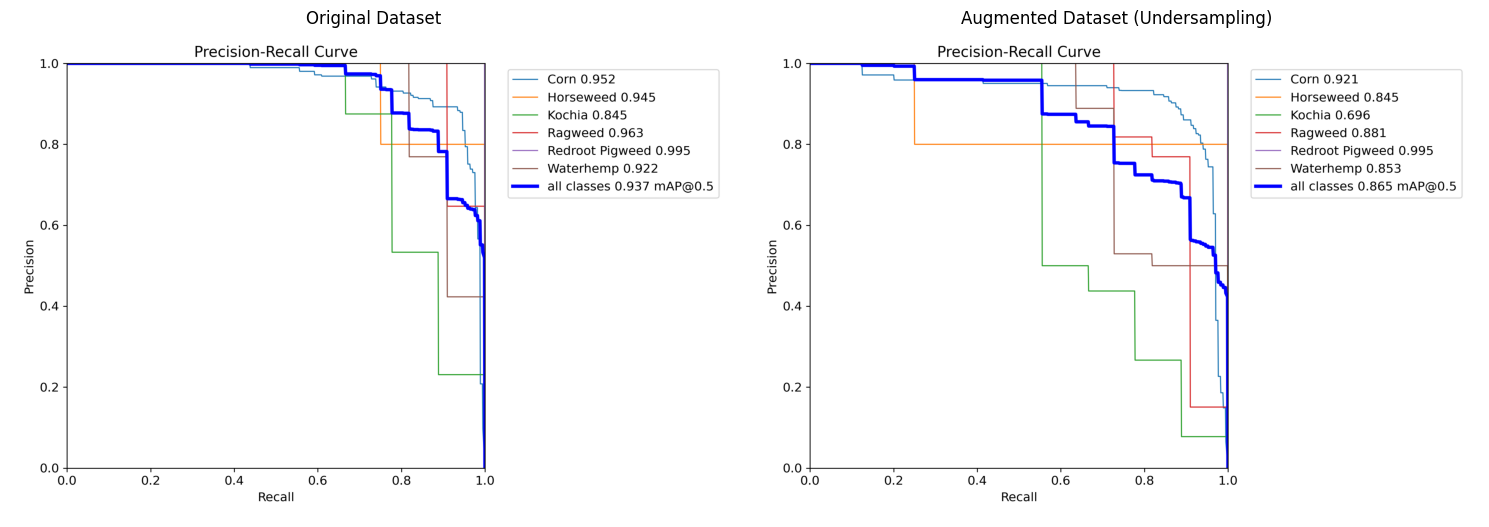

In [31]:
%matplotlib inline
PATH_ORIGINAL = Path('runs/corn_original_dataset_yolov11n/training_results/BoxPR_curve.png')
PATH_AUGMENTED = Path('runs/corn_baseline_yolov11n/training_results/BoxPR_curve.png') 

img_original = Image.open(PATH_ORIGINAL)
img_augmented = Image.open(PATH_AUGMENTED)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(img_original)
axes[0].set_title('Original Dataset')
axes[0].axis('off') 

axes[1].imshow(img_augmented)
axes[1].set_title('Augmented Dataset (Undersampling)')
axes[1].axis('off') 

plt.tight_layout()
plt.show()